In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# ✅ Kiểm tra GPU trước khi chạy model
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print(f"✅ PyTorch nhận GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ WARNING: PyTorch không nhận GPU! Chạy trên CPU.")


✅ PyTorch nhận GPU: NVIDIA GeForce GTX 1650
CUDA version: 12.1


In [3]:

# ✅ Cấu hình đường dẫn dataset
DATASET_PATH = "D:/Capstone/Final_CLD_data"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# ✅ Cấu hình tham số
IMG_SIZE = 224
BATCH_SIZE = 16 
EPOCHS = 3

# ✅ Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load Dataset 
train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=transform)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=transform)

# ✅ Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# ✅ Load mô hình ConvNeXt-Tiny
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
num_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_features, len(train_dataset.classes))  # Điều chỉnh output layer
model = model.to(DEVICE)  # Chuyển model lên GPU

# ✅ Kiểm tra xem model có thực sự chạy trên GPU không
print(f"Model is running on: {next(model.parameters()).device}")

Train: 124999, Validation: 25000, Test: 5860
Model is running on: cuda:0


In [4]:
# ✅ Cấu hình hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# ✅ Biến lưu loss & accuracy
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# ✅ Hàm huấn luyện
def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)  # Chuyển dữ liệu lên GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct/total)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        val_acc, val_loss = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_acc:.4f} | Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

In [5]:
# ✅ Hàm đánh giá mô hình
def evaluate(model, loader):
    model.eval()
    correct, total, total_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total, total_loss / len(loader)

# ✅ Kiểm tra xem dữ liệu có thực sự chạy trên GPU không 
for images, labels in train_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    print(f"Batch is running on: {images.device}")  
    break  

# ✅ Bắt đầu huấn luyện
train(model, train_loader, val_loader, EPOCHS)

Batch is running on: cuda:0


Epoch 1/3: 100%|██████████| 7813/7813 [2:49:59<00:00,  1.31s/it, acc=0.993, loss=9.39e-5]   


Epoch 1/3 | Train Acc: 0.9929 | Val Acc: 0.9931 | Loss: 0.0218 | Val Loss: 0.0273


Epoch 2/3: 100%|██████████| 7813/7813 [2:50:48<00:00,  1.31s/it, acc=0.997, loss=7.84e-5]   


Epoch 2/3 | Train Acc: 0.9974 | Val Acc: 0.9983 | Loss: 0.0085 | Val Loss: 0.0056


Epoch 3/3: 100%|██████████| 7813/7813 [2:49:15<00:00,  1.30s/it, acc=0.998, loss=0.000547]  


Epoch 3/3 | Train Acc: 0.9982 | Val Acc: 0.9978 | Loss: 0.0063 | Val Loss: 0.0072


In [6]:
# ✅ Đánh giá mô hình trên tập test
test_acc, test_loss = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

# ✅ Lưu mô hình vào ổ D 
MODEL_SAVE_PATH = "D:/Capstone/models/convnext_tiny_coffee.pth"
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)  
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Test Accuracy: 0.9998
Model saved to D:/Capstone/models/convnext_tiny_coffee.pth


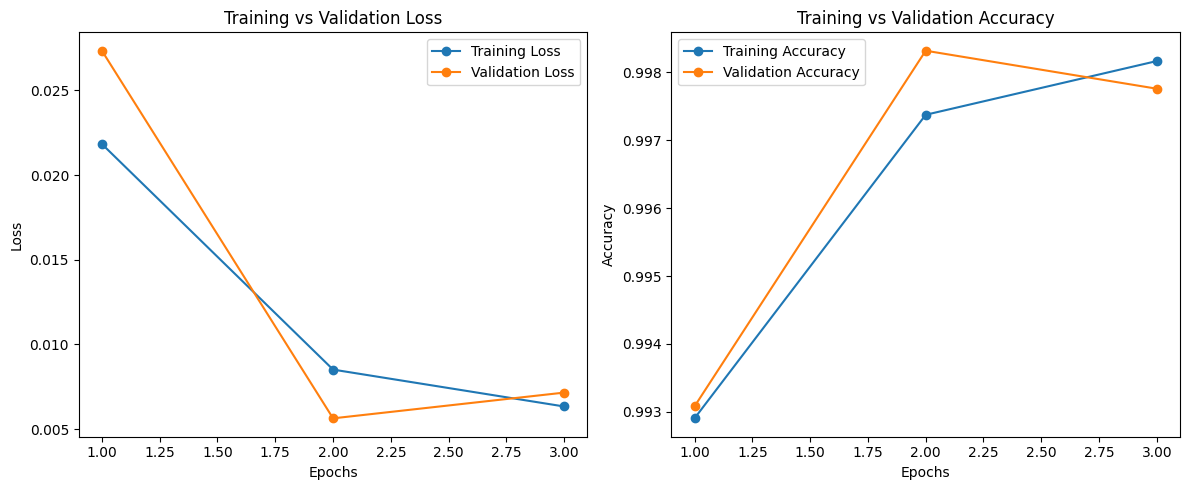

In [7]:
# ✅ Trực quan hóa quá trình huấn luyện
plt.figure(figsize=(12, 5))

# Vẽ Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Vẽ Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label="Training Accuracy", marker="o")
plt.plot(range(1, EPOCHS + 1), val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()